In [33]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.image as mpimg

In [45]:
rng = np.random.default_rng()

# this rolls one n_dice with n_sides once each. 
def roll_dice(n_sides, n_dice):
    return (rng.integers(low = 1, high = n_sides, size = n_dice, endpoint=True)).tolist()


# Let's reform the roll and attack functions so that they are markov chaning
def attack_m(n_a_troops, n_d_troops, n_a_dice=3, n_a_sides=6, n_d_sides=6, debug=False):
    # m stands for matrix output
    # n_a_troops is the number of troops on the board in attackers position
    # n_d_troops is the number of troops on the board in the defenders position
    # n_a_dice is the number of attack dice desired to be rolled each time
    # n_a_sides is number of sides on the attack dice (usually 6)
    # n_d_sides is numer of sides on the defend dice (usually 6)
    
    # number of defending dice. always assumed to be 2 unless less troops available
    ndd = 2
    
    score = np.zeros((n_a_troops, n_d_troops+1), dtype=int)
    
    # no troops left to attack or defend with
    # this while condition assumes we're fighting to the death
    while (n_a_troops > 1 and n_d_troops > 0):
        # attack!
        # n_a_sides is n_a_sides unless less troops available. fight to the death!
        nad = n_a_troops-1 if n_a_troops -1 < n_a_dice else n_a_dice
        ndd = n_d_troops if n_d_troops < ndd else ndd
        
        min_die = min([nad, ndd])
        
        a_rolls = roll_dice(n_a_sides, nad)
        d_rolls = roll_dice(n_d_sides, ndd)
        
        a_rolls.sort(reverse=True)
        d_rolls.sort(reverse=True)
        
        if debug:
            print("a rolls: ", a_rolls)
            print("d rolls: ", d_rolls)
        for i in range(min_die):
            if a_rolls[i] > d_rolls[i]:
                n_d_troops -=1
            else:
                n_a_troops -=1
        
        score[n_a_troops-1][n_d_troops] +=1
        if debug:
            print(score)
    
    return score

def attack_stats_m(n_a_troops, n_d_troops, n_a_dice=3, n_iter=10000, n_a_sides=6, n_d_sides=6):
    results = np.zeros((n_a_troops, n_d_troops+1), dtype=int)
    for i in range(n_iter):
        end_state = attack_m(n_a_troops, n_d_troops, n_a_dice, n_a_sides, n_d_sides)
        results += end_state
    
    return results

def result_from_matrix(score_matrix):
    defenders_left = score_matrix[0][1:].tolist()
    defenders_left.reverse()
    attackers_left = []
    for i in range(1, len(score_matrix)):
        attackers_left.append(score_matrix[i][0])

    result = defenders_left + attackers_left
    return result, len(defenders_left)

def plot_single_at_least(score, picture=None):
    result, pivot = result_from_matrix(score)
    result.reverse()

    sum_array = [result[0]]
    for i in range(1,len(result)):
        sum_array.append(sum_array[-1] + result[i])

    result = [ i / max(sum_array) for i in sum_array]
    result.reverse()

    n_attackers = len(result)-pivot+1

    x_ticks = np.arange(-pivot, 0).tolist() + np.arange(2,n_attackers+1).tolist()
    x_ticks_s = [str(i) for i in x_ticks]
    
    ## plot stuff
    if picture == None:
        fig, ax = plt.subplots()
    else:
        fig, axs = plt.subplots(1,2, figsize=(10,5))
        arr_pic = mpimg.imread('img/'+picture)
        axs[0].imshow(arr_pic)
        axs[0].set_xticks([])
        axs[0].set_yticks([])
        ax = axs[1]
        
    ax.plot(range(len(result)), result, label="5v5", marker='s')
    ax.set_xticks(range(len(result)))
    ax.set_xticklabels(x_ticks_s)
    ax.yaxis.set_major_formatter(mticker.PercentFormatter(1,decimals=0))
    ax.set_yticks(np.arange(0,1,.05), minor=True)
    ax.grid(which='both')
    ax.grid(which='minor', alpha=0.5, linestyle=':')
    ax.axhline(y=result[pivot])
    loss = "loss: {:.1f}%".format(100*(1-result[pivot]))
    win  = "win:  {:.1f}%".format(100*result[pivot])
    ax.text(0, result[pivot]+.03, loss, color = "red")
    ax.text(0, result[pivot]-.05, win, color = "green")

    plt.show()

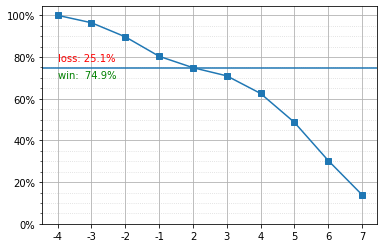

In [36]:
plot_single_at_least(attack_stats_m(7,4))

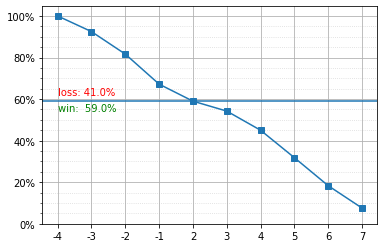

In [37]:
plot_single_at_least(attack_stats_m(7,4, n_d_sides=7))

## Let's try a few examples

### 3 vs 1, defender with 7 sides

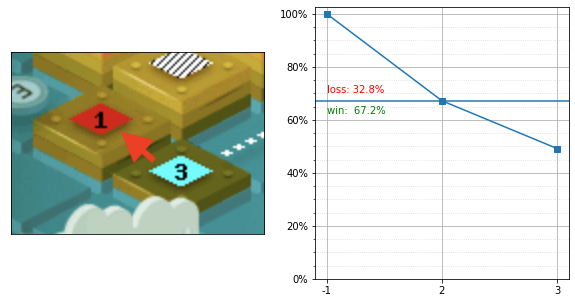

In [49]:
plot_single_at_least(attack_stats_m(3,1, n_d_sides=7), picture = '3v1.png')

### 4 vs 6, defender with 7 sides

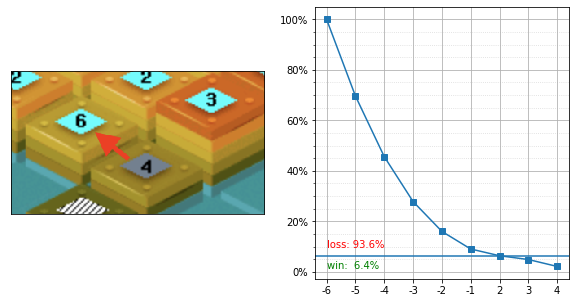

In [48]:
plot_single_at_least(attack_stats_m(4,6, n_d_sides=7), picture = '4v6.png')

### 4 vs 3, defender with 9 sides

In [ ]:
plot_single_at_least(attack_stats_m(4,3, n_d_sides=9), picture = '4v3.png')

### 5 vs 3, defender with 7 sides
![alt text](img/5v3.png)

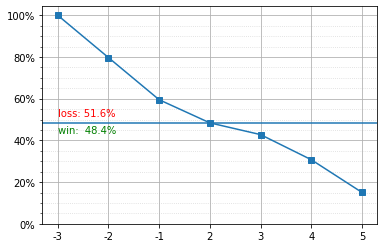

In [30]:
plot_single_at_least(attack_stats_m(5,3, n_d_sides=7))